# Biblioteke

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits.mplot3d import Axes3D

# Pregled podataka

In [7]:
file_path = "Multi-Sensor_Medical_IoT_Dataset.csv"
df = pd.read_csv(file_path)

In [241]:
print("Prvih 5 redova:")
display(df.head())

Prvih 5 redova:


,patient_id,heart_rate,spo2_level,ecg_signal,respiration_rate,body_temperature,blood_pressure_sys,blood_pressure_dia,blood_glucose,eeg_alpha_power,eeg_beta_power,emg_signal_strength,fall_detected,activity_type,step_count,latitude,longitude,ambient_temperature,stress_level_index,timestamp
0,P075,62,98.4,-0.001,14,36.2,125,86,117.5,9.70,7.63,0.59,0,walking,1497,12.91225,77.50750,25.2,48,2025-07-08T06:47:01.581419
1,P019,75,98.7,0.123,14,36.3,120,85,142.7,11.84,7.22,0.47,0,running,1428,12.92120,77.58957,28.8,77,2025-07-08T06:46:01.581435
2,P039,89,94.0,-0.580,18,37.2,130,84,94.6,9.42,4.26,0.94,0,resting,547,12.90295,77.58027,34.0,55,2025-07-08T06:45:01.581440
3,P078,82,92.2,0.400,14,37.0,115,82,162.3,7.32,6.77,0.22,1,sleeping,960,12.94339,77.51395,27.7,46,2025-07-08T06:44:01.581443
4,P005,87,97.8,-0.146,18,36.6,118,84,103.5,9.76,6.29,0.67,0,running,131,12.92778,77.57768,27.7,7,2025-07-08T06:43:01.581446


**Analiza Strukture Podataka**

**Identifikatori**
- `patient_id` → identifikator pacijenta (kategorijska varijabla, nije numerička)

---

**Fiziološki Signali**
- `heart_rate` → broj otkucaja srca
- `spo2_level` → nivo zasićenosti kiseonikom
- `ecg_signal` → elektrokardiogram
- `respiration_rate` → broj udisaja
- `body_temperature` → telesna temperatura
- `blood_pressure_sys` / `blood_pressure_dia` → sistolni/dijastolni pritisak
- `blood_glucose` → nivo šećera u krvi

---

**EEG / EMG Signali**
- `eeg_alpha_power` → snaga alfa talasa
- `eeg_beta_power` → snaga beta talasa
- `emg_signal_strength` → jačina EMG signala

---

**Kontekstualni Podaci**
- `fall_detected` → detekcija pada (binarna varijabla: 0/1)
- `activity_type` → tip aktivnosti (kategorijska varijabla)
- `step_count` → broj koraka
- `latitude`, `longitude` → geolokacija
- `ambient_temperature` → spoljašnja temperatura

---

**Vremenska Dimenzija**
- `timestamp` → vremenska oznaka

---

**Analitički Kandidati**

**Binning Kandidati**
- `heart_rate`
- `body_temperature`
- `stress_level_index`
- `blood_glucose`

> Primer: kategorije *low / normal / high* na osnovu medicinskih opsega

---

**Outlier Analiza Kandidati**
- `ecg_signal`
- `blood_glucose`
- `eeg_alpha_power`, `eeg_beta_power`
- `step_count`

---

**Regresija**

**Ciljna varijabla: `stress_level_index`**
- **Regresija** uz korišćenje fizioloških i kontekstualnih signala kao ulaza

---

**Filteri za Selekciju Atributa**
Mogući kandidati za isključivanje (nema značajnog doprinosa u modelima za stres/pad):
- `latitude`
- `longitude`

**Metode selekcije:**
- Ensemble Filter
- Cross-Validated Committees Filter
- Iterative-Partitioning Filter

In [243]:
print("\nInfo o datasetu:")
print(df.info())


Info o datasetu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           670 non-null    object 
 1   heart_rate           670 non-null    int64  
 2   spo2_level           670 non-null    float64
 3   ecg_signal           670 non-null    float64
 4   respiration_rate     670 non-null    int64  
 5   body_temperature     670 non-null    float64
 6   blood_pressure_sys   670 non-null    int64  
 7   blood_pressure_dia   670 non-null    int64  
 8   blood_glucose        670 non-null    float64
 9   eeg_alpha_power      670 non-null    float64
 10  eeg_beta_power       670 non-null    float64
 11  emg_signal_strength  670 non-null    float64
 12  fall_detected        670 non-null    int64  
 13  activity_type        670 non-null    object 
 14  step_count           670 non-null    int64  
 15  latitude             6

**Detaljna Analiza Atributa (na osnovu df.info)**

---

**Binning: Numeričke Kontinuirane Promenljive**

Sledeće promenljive su tipa `int64` / `float64`, što ih čini pogodnim za binning (kategorizaciju):

- `heart_rate`
- `spo2_level`
- `respiration_rate`
- `body_temperature`
- `blood_glucose`
- `stress_level_index`

> Primer: `stress_level_index` (0–100) može se kategorizovati kao:
- `low` (0–33)
- `medium` (34–66)
- `high` (67–100)

---

**Outlier Analiza**

- Svi atributi imaju **670 vrednosti**
- **Nema `null` vrednosti**
- Fokus analize: **ekstremne vrednosti** (outliers), a ne praznine

---

**Regresija**

- **Regresija**:
  - Ciljna varijabla: `stress_level_index` (kontinuirana numerička)
  - Ulazne promenljive: fiziološki i kontekstualni podaci

---

**Filter Metode za Selekciju Atributa**

**Kandidati za izbacivanje (nema informativnu vrednost za model):**
- `patient_id`
- `timestamp`

**Kategorijska promenljiva:**
- `activity_type` → konvertovati u `dummy` promenljive (`OneHotEncoder`)
- Proveriti značaj pomoću:
  - **Ensemble Filter**
  - **Cross-Validated Committees Filter**
  - **Iterative-Partitioning Filter**

In [10]:
numeric_df = df.select_dtypes(include=["int64", "float64"])

In [249]:
print("Numeričke kolone:")
print(numeric_df.columns)

Numeričke kolone:
Index(['heart_rate', 'spo2_level', 'ecg_signal', 'respiration_rate',
       'body_temperature', 'blood_pressure_sys', 'blood_pressure_dia',
       'blood_glucose', 'eeg_alpha_power', 'eeg_beta_power',
       'emg_signal_strength', 'fall_detected', 'step_count', 'latitude',
       'longitude', 'ambient_temperature', 'stress_level_index'],
      dtype='object')


In [251]:
print("\nStatistika:")
display(numeric_df.describe())


Statistika:


,heart_rate,spo2_level,ecg_signal,respiration_rate,body_temperature,blood_pressure_sys,blood_pressure_dia,blood_glucose,eeg_alpha_power,eeg_beta_power,emg_signal_strength,fall_detected,step_count,latitude,longitude,ambient_temperature,stress_level_index
count,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000,670.000000
mean,79.592537,96.041940,0.015084,15.647761,36.787463,124.517910,79.456716,129.637761,9.453791,5.962075,0.580910,0.041791,798.916418,12.950472,77.551541,29.981045,48.971642
std,11.372597,2.312975,0.209050,2.282995,0.501201,8.451858,5.847367,28.875152,1.456013,1.132387,0.228854,0.200261,439.143880,0.028852,0.028437,2.973598,29.871735
min,60.000000,92.000000,-0.586000,12.000000,35.100000,110.000000,70.000000,80.400000,7.000000,4.000000,0.200000,0.000000,0.000000,12.900090,77.500250,25.000000,0.000000
25%,70.000000,94.000000,-0.116750,14.000000,36.400000,117.000000,74.000000,104.350000,8.182500,5.010000,0.380000,0.000000,410.750000,12.925520,77.527407,27.400000,22.000000
50%,80.000000,96.200000,0.020000,16.000000,36.800000,125.000000,79.000000,129.500000,9.410000,5.970000,0.560000,0.000000,843.000000,12.950290,77.552590,29.800000,50.000000
75%,89.000000,98.000000,0.146750,18.000000,37.200000,132.000000,85.000000,154.875000,10.802500,6.860000,0.770000,0.000000,1168.500000,12.975843,77.575727,32.700000,73.000000
max,99.000000,99.900000,0.652000,19.000000,38.300000,139.000000,89.000000,179.900000,12.000000,8.000000,1.000000,1.000000,1497.000000,12.999950,77.599970,35.000000,100.000000


**Statistička Analiza: `numeric_df.describe()`**

---

**Binning (Diskretizacija) – Na osnovu vrednosti**

**1. `heart_rate`**  
- Opseg: **60 – 99**, Prosek ≈ **80**
- Predložene kategorije:
  - `Low`: <70  
  - `Normal`: 70–90  
  - `High`: >90  

**2. `spo2_level`**  
- Opseg: **92 – 99.9**
- Predložene kategorije:
  - `Normal`: 95–100  
  - `Borderline`: 92–95  

**3. `body_temperature`**  
- Opseg: **35.1 – 38.3**
- Predložene kategorije:
  - `Hypothermia`: <36  
  - `Normal`: 36–37.5  
  - `Fever`: >37.5  

**4. `stress_level_index`**  
- Opseg: **0 – 100**
- Predložene kategorije:
  - `Low`: 0–33  
  - `Medium`: 34–66  
  - `High`: 67–100  

---

**Outlier Analiza – Kandidati i Zapažanja**

**1. `step_count`**
- Min: 0, Max: 1497, Medijan: 843
- Zapažanje: `0` može značiti da osoba nije hodala, ali i grešku u uređaju  
- Max vrednost deluje ekstremno → potreban boxplot/outlier analiza

**2. `blood_glucose`**
- Min: 80.4, Max: 179.9
- Ako su pacijenti zdravi, vrednosti >160 mogu biti outlieri

**3. `ecg_signal`**
- Opseg: -0.586 do 0.652
- Širok raspon, preporučuje se vizualizacija (boxplot)

**4. `emg_signal_strength`**
- Opseg: 0.2 do 1.0
- Verovatno normalizovan signal, možda nije outlier

**5. `stress_level_index`**
- Opseg: 0 do 100
- Vrednosti 0 i 100 mogu biti ekstremne u zavisnosti od kliničkog značenja

---

**Regresija**

- `stress_level_index` pokriva čitav numerički opseg (0–100)
- Dobro balansiran kandidat za **regresiju**

---

**Selekcija Atributa (Filter Metode)**

**Moguće manje značajne kolone:**
- `spo2_level`: Mali raspon (92–99.9), verovatno mala varijabilnost → možda ne doprinosi modelu

**Moguće značajne kolone:**
- `step_count`
- `blood_glucose`
- `stress_level_index`

> Velika varijabilnost ovih atributa može ukazivati na značajnu prediktivnu vrednost

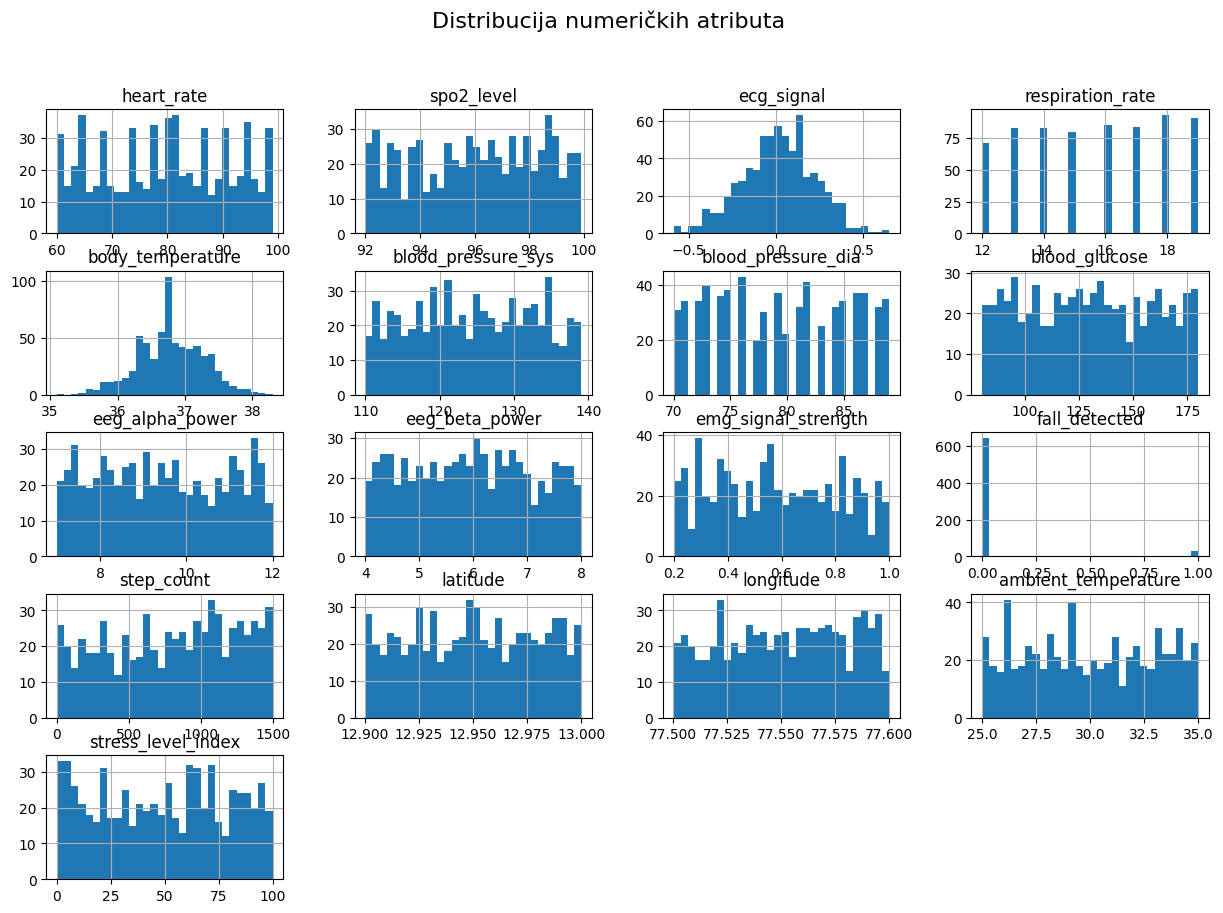

In [253]:
numeric_df.hist(bins=30, figsize=(15,10))
plt.suptitle("Distribucija numeričkih atributa", fontsize=16)
plt.show()

**Analiza Distribucija (Histogrami Numeričkih Atributa)**

---

**Binning (Diskretizacija)**

**1. `heart_rate`**  
- Skoro **uniformna distribucija**  
- Lako se podeli u kategorije (`low`, `normal`, `high`)

**2. `stress_level_index`**  
- Vidljivi šiljci pri vrednostima **0**, **50** i **100**  
- Odličan kandidat za kategorizaciju (`low`, `medium`, `high`)

**3. `body_temperature`**  
- Prati **normalnu distribuciju**  
- Idealno za binning prema **medicinskim pragovima**  
  (npr. `hypothermia`, `normal`, `fever`)

---

**Outlier Analiza (na osnovu histograma)**

**1. `step_count`**  
- Jasna grupa kod **0** → može ukazivati na:
  - Device error  
  - Pacijente u mirovanju  
- Kandidat za **outlier cleaning**

**2. `blood_glucose`**  
- Histogram pokazuje **"rep"** ka višim vrednostima  
- Moguće outlier vrednosti na gornjoj granici

**3. `ecg_signal`**  
- Raspodela oko **0** (normalna)  
- Ekstremne vrednosti vidljive na krajevima

**4. `ambient_temperature`**  
- Skoro **uniformna distribucija**  
- Proveriti za **ekstremno niske/visoke vrednosti** (npr. <25 ili >35)

---

**Regresija – Varijabilnost atributa**

- Atributi sa izraženom varijabilnošću (vidljivo u histogramima):
  - `heart_rate`
  - `blood_glucose`
  - `stress_level_index`

- Skoro uniformne promenljive:
  - `latitude`, `longitude` → verovatno **niska prediktivna moć** za `stress_level_index`

---

**Filter Metode: Ensemble / Committees / Iterative Partitioning**

**Kandidati za eliminaciju:**
- `latitude`, `longitude`  
  - Skoro **uniformni**
  - **Ne sadrže medicinski značajnu informaciju**

**Specifični slučaj** - `fall_detected`:  
  - **Neuravnotežena klasa** (dominira vrednost `0`)  
  - Može uticati na filter metode

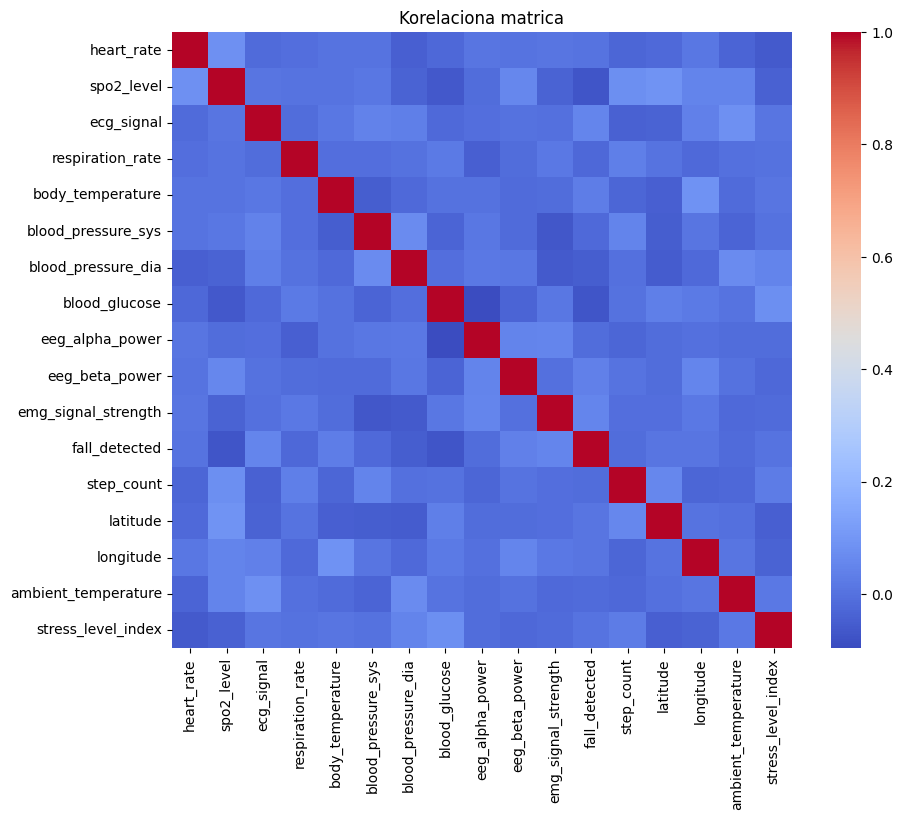

In [255]:
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Korelaciona matrica")
plt.show()

**Analiza Korelacione Matrice**

---

**Opšta Korelacija**

- Većina korelacionih vrednosti ≈ **0** (vizuelno: tamno plavi kvadrati)
- Promenljive su **slabo međusobno povezane**
- Nema jakih korelacija (> 0.7), osim trivijalnih (dijagonala = 1)

---

**Impikacije na Modeliranje**

- **Linearna regresija** može imati **slabije performanse**, jer se oslanja na linearnu povezanost atributa
- Nema potrebe za eliminacijom atributa zbog **multikolinearnosti**, jer nema značajne redundanse među kolonama

---

**Ensemble i Napredne Metode**

- **Ensemble metode** (npr. Random Forest, Gradient Boosting):
  - Ne zavise isključivo od linearnih veza
  - Mogu prepoznati **nelinearne obrasce**
    

- **Iterative Partitioning Filter**:
  - Analizira i **nelinearne zavisnosti**
  - Može identifikovati značajne prediktore iako nisu linearno korelisani sa ciljnom varijablom

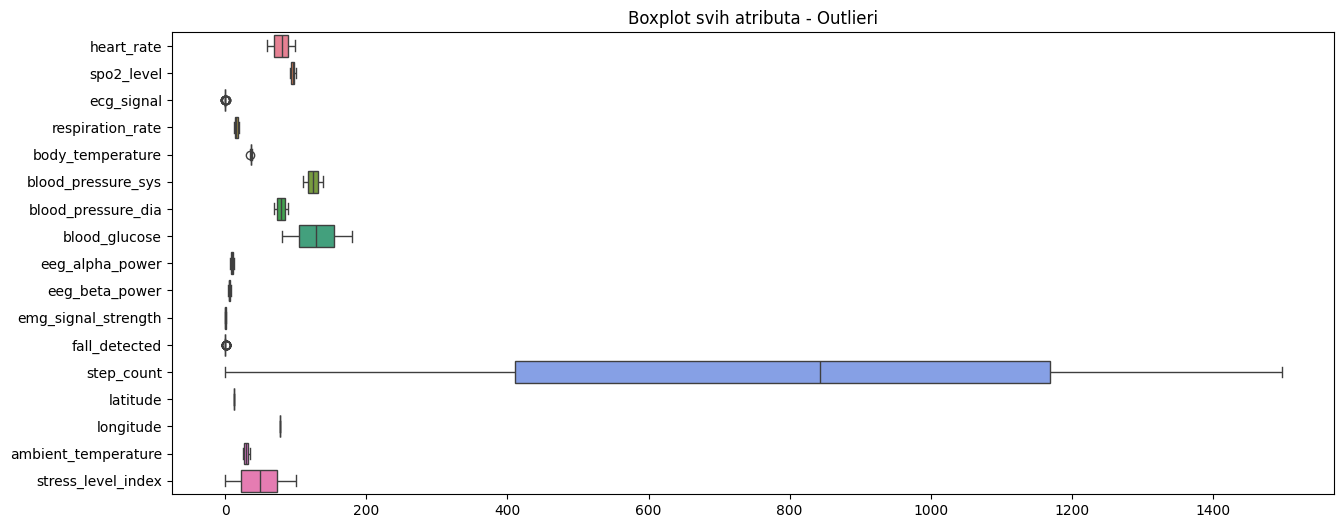

In [29]:
plt.figure(figsize=(15,6))
sns.boxplot(data=numeric_df, orient="h")
plt.title("Boxplot svih atributa - Outlieri")
plt.show()

**Boxplot Analiza Numeričkih Atributa**

---

**Normalizacija i Rasponi**

- Većina numeričkih atributa izgleda **normalizovano** (slični rasponi)
- `step_count` značajno **odskače**:
  - Raspon ide **preko 1000**
  - Može **dominirati modelima** (npr. regresiji) ako se ne izvrši:
    - **Standardizacija** (npr. Z-score)
    - ili **Normalizacija** (Min-Max)

---

**Outlieri**

- Outlieri su prisutni u **skoro svim atributima**

---

**Diskretne Varijable**

- Promenljive poput `fall_detected` (vrednosti 0/1) imaju **spljošten prikaz** na boxplotu
- Nisu pogodne za outlier analizu
- Treba ih tretirati kao **kategorijske varijable**

# Primena tehnika

## Smoothing tehnike

### Binning

In [12]:
data = df[["stress_level_index"]].copy()

In [259]:
print("Originalne vrednosti (prvih 10):")
print(data.head(10))

Originalne vrednosti (prvih 10):
   stress_level_index
0                  48
1                  77
2                  55
3                  46
4                   7
5                  54
6                  87
7                  17
8                  34
9                  88


> **Binovanje sa jednakom širinom (Equal Width)**

In [14]:
eq_width = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="uniform")
data["bin_equal_width"] = eq_width.fit_transform(data[["stress_level_index"]])

> **Binovanje sa jednakom frekvencijom (Equal Frequency)**

In [16]:
eq_freq = KBinsDiscretizer(n_bins=3, encode="ordinal", strategy="quantile")
data["bin_equal_freq"] = eq_freq.fit_transform(data[["stress_level_index"]])

In [18]:
def smooth_by_means(values):
    return np.full_like(values, np.mean(values))

def smooth_by_medians(values):
    return np.full_like(values, np.median(values))

def smooth_by_boundaries(values):
    min_val, max_val = np.min(values), np.max(values)
    return np.array([min_val if abs(v-min_val) < abs(v-max_val) else max_val for v in values])

> **Izglađivanje binova po Equal Width**

In [20]:
data["smooth_means"] = 0
data["smooth_medians"] = 0
data["smooth_boundaries"] = 0

for b in sorted(data["bin_equal_width"].unique()): # izglađivanje na binovima dobijenim equal width strategijom
    bin_values = data.loc[data["bin_equal_width"] == b, "stress_level_index"]
    
    data.loc[data["bin_equal_width"] == b, "smooth_means"] = smooth_by_means(bin_values)
    data.loc[data["bin_equal_width"] == b, "smooth_medians"] = smooth_by_medians(bin_values)
    data.loc[data["bin_equal_width"] == b, "smooth_boundaries"] = smooth_by_boundaries(bin_values)

In [22]:
print("\nPrimer binovanih i izglađenih vrednosti (prvih 10):")
print(data.head(10)[["stress_level_index", "bin_equal_width", "smooth_means", "smooth_medians", "smooth_boundaries"]])


Primer binovanih i izglađenih vrednosti (prvih 10):
   stress_level_index  bin_equal_width  smooth_means  smooth_medians  \
0                  48              1.0            51              51   
1                  77              2.0            83              84   
2                  55              1.0            51              51   
3                  46              1.0            51              51   
4                   7              0.0            15              14   
5                  54              1.0            51              51   
6                  87              2.0            83              84   
7                  17              0.0            15              14   
8                  34              1.0            51              51   
9                  88              2.0            83              84   

   smooth_boundaries  
0                 34  
1                 67  
2                 66  
3                 34  
4                  0  
5               

> **Izglađivanje binova po Equal Frequency**

In [24]:
data["smooth_means_freq"] = 0
data["smooth_medians_freq"] = 0
data["smooth_boundaries_freq"] = 0

for b in sorted(data["bin_equal_freq"].unique()):
    bin_values = data.loc[data["bin_equal_freq"] == b, "stress_level_index"]
    
    data.loc[data["bin_equal_freq"] == b, "smooth_means_freq"] = smooth_by_means(bin_values)
    data.loc[data["bin_equal_freq"] == b, "smooth_medians_freq"] = smooth_by_medians(bin_values)
    data.loc[data["bin_equal_freq"] == b, "smooth_boundaries_freq"] = smooth_by_boundaries(bin_values)

In [26]:
print("\nPrimer binovanih i izglađenih vrednosti (prvih 10):")
print(data.head(10)[[
    "stress_level_index", "bin_equal_freq", "smooth_means_freq", "smooth_medians_freq", "smooth_boundaries_freq"
]])


Primer binovanih i izglađenih vrednosti (prvih 10):
   stress_level_index  bin_equal_freq  smooth_means_freq  smooth_medians_freq  \
0                  48             1.0                 49                   50   
1                  77             2.0                 82                   83   
2                  55             1.0                 49                   50   
3                  46             1.0                 49                   50   
4                   7             0.0                 14                   13   
5                  54             1.0                 49                   50   
6                  87             2.0                 82                   83   
7                  17             0.0                 14                   13   
8                  34             1.0                 49                   50   
9                  88             2.0                 82                   83   

   smooth_boundaries_freq  
0                      32  

### Regresija

In [275]:
X = df[["heart_rate"]] # X = nezavisna promenljiva
y = df["stress_level_index"] # y = stress_level_index

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

> **Jednostavna linearna regresija**

In [277]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

In [101]:
print("Jednostavna linearna regresija:")
print("Koeficijent (p1):", lin_reg.coef_[0])
print("Intercept (p0):", lin_reg.intercept_)
print("R2 score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

Jednostavna linearna regresija:
Koeficijent (p1): -0.14579715330163728
Intercept (p0): 59.64295891081515
R2 score: -0.5703125
MSE: 0.06716417910447761


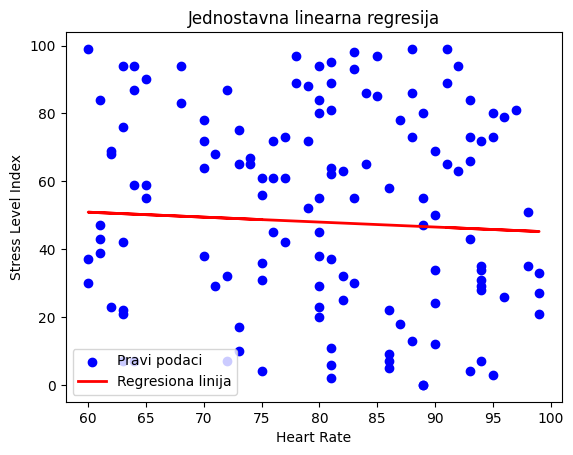

In [281]:
plt.scatter(X_test, y_test, color="blue", label="Pravi podaci")
plt.plot(X_test, y_pred, color="red", linewidth=2, label="Regresiona linija")
plt.xlabel("Heart Rate")
plt.ylabel("Stress Level Index")
plt.legend()
plt.title("Jednostavna linearna regresija")
plt.show()

**1. Koeficijent (p₁) = **-0.1458****

- To je nagib regresione linije.  
- Znak je **negativan**, što znači da kako **srčani puls raste**, **stresni indeks blago opada**.
- **Konkretno**: porast pulsa za 1 otkucaj u minuti → stresni indeks se **smanjuje za oko 0.15 jedinica**.
- Međutim, **nagib je vrlo mali**, što znači da je **uticaj praktično zanemarljiv**.

---

**2. Intercept (p₀) = **59.64****

- To je vrednost **Stress Level Index** kada je **Heart Rate = 0**.
- Pošto **nema smisla** da je puls 0 u realnom životu, ovo je samo **matematička konstanta** da bi se linija uklopila u podatke.
- Dakle, **nema praktičnu interpretaciju**, osim da **pomerа liniju naviše**.

---

**3. R² score = **-0.018****

- R² meri koliko dobro model objašnjava varijansu podataka.
- Idealno: **R² = 1** (savršeno objašnjenje).
- Ako je **blizu 0** → model ne objašnjava podatke.
- Ako je **negativan** → regresiona linija je **gora od horizontalne linije kroz prosek podataka**.

To znači da **Heart Rate praktično nema prediktivnu moć** za **Stress Level Index** u ovom skupu podataka.

---

**4. MSE = **860.26****

- MSE (Mean Squared Error) meri **prosečnu kvadratnu grešku**.
- Vrednost je **relativno visoka** (jer **Stress Level Index ide od 0 do 100**).
- Ovo potvrđuje da **linearni model ne daje dobru predikciju**.

> **Višestruka linearna regresija**

In [29]:
features = ["heart_rate", "blood_glucose"]

X = df[features]
y = df["stress_level_index"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

multi_reg = LinearRegression()
multi_reg.fit(X_train, y_train)

y_pred_multi = multi_reg.predict(X_test)

In [31]:
print("\nVišestruka linearna regresija:")
print("Koeficijenti:", dict(zip(features, multi_reg.coef_)))
print("Intercept:", multi_reg.intercept_)
print("R2 score:", r2_score(y_test, y_pred_multi))
print("MSE:", mean_squared_error(y_test, y_pred_multi))


Višestruka linearna regresija:
Koeficijenti: {'heart_rate': -0.13725985708999758, 'blood_glucose': 0.06261902001590589}
Intercept: 50.8461455777409
R2 score: -0.005079008498917625
MSE: 849.3636894775268


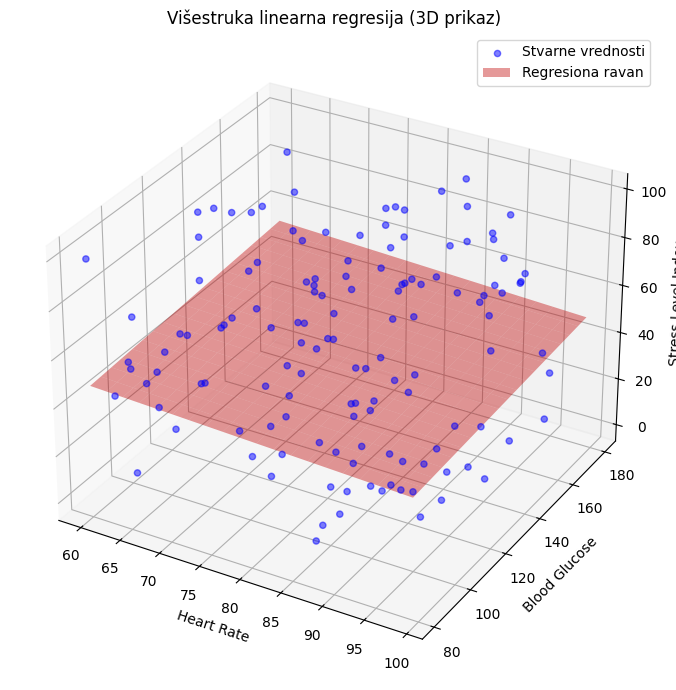

In [39]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = X_test["heart_rate"]
z = X_test["blood_glucose"]
y = y_test 

ax.scatter(x, z, y, color='blue', label='Stvarne vrednosti', alpha=0.5)

x_surf, z_surf = np.meshgrid( # Mreža za x i z (heart_rate i blood_glucose) = regresiona ravan
    np.linspace(x.min(), x.max(), 20),
    np.linspace(z.min(), z.max(), 20)
)

y_surf = (multi_reg.intercept_ +
          multi_reg.coef_[0] * x_surf +
          multi_reg.coef_[1] * z_surf)

ax.plot_surface(x_surf, z_surf, y_surf, alpha=0.4, color='red', label='Regresiona ravan')

ax.set_xlabel("Heart Rate")
ax.set_ylabel("Blood Glucose")
ax.set_zlabel("Stress Level Index")
ax.set_title("Višestruka linearna regresija (3D prikaz)")

plt.legend()
plt.tight_layout()
plt.show()

Model višestruke linearne regresije napravljen je sa dva ulazna atributa:

- `heart_rate` (broj otkucaja srca)
- `blood_glucose` (nivo šećera u krvi)

Cilj modela: predikcija `stress_level_index` (na skali od 0 do 100)

---

**Rezultati regresije (numerički izlaz)**

- Koeficijenti su vrlo mali → `heart_rate` i `blood_glucose` **skoro da nemaju uticaj** na stres indeks.
  - `heart_rate`: svaki otkucaj više → smanjenje stresa za ~0.14 (zanemarljivo)
  - `blood_glucose`: svaki poen više → povećanje stresa za ~0.06 (takođe zanemarljivo)
- Intercept (50.85): model predviđa prosečan stres kada su ulazne vrednosti 0 (teoretski).
- R² = -0.005: model **ne objašnjava varijaciju** ciljne promenljive.
- MSE = 849.36: velika srednja kvadratna greška → **loše predikcije**.

---

**Vizuelni prikaz modela (3D)**

- X-osa: `heart_rate`
- Z-osa: `blood_glucose`
- Y-osa (vertikalna): `stress_level_index`

Plave tačke:
- Prave vrednosti iz test skupa.
- Prikazuju stvarnu distribuciju stresa.

Crvena ravan:
- Regresiona ravan naučena od modela.
- Prikazuje očekivane vrednosti stresa po modelu.

Vizuelni uvid:
- Ravan je skoro **ravna** → model daje slične vrednosti nezavisno od ulaza.
- Većina tačaka je **daleko od ravni** → model ne hvata obrasce u podacima.
- Potvrđuje numerički zaključak: **loš model**.

---

Model **nije uspešan** jer:

- `heart_rate` i `blood_glucose` **ne objašnjavaju dovoljno** stres.
- Model je **previše jednostavan** za kompleksan problem.
- I metrički i vizuelni pokazatelji ukazuju na **slab kvalitet predikcije**.

### Outlier analysis

In [313]:
X = numeric_df

**Standardizacija**

In [315]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

> **Statistical based approach**

**Z-score metoda**

In [317]:
z_scores = np.abs(stats.zscore(X))
z_outliers = (z_scores > 3)   # True ako je outlier
df["outlier_zscore"] = z_outliers.any(axis=1)

**IQR metoda**

In [319]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
iqr_outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR)))
df["outlier_iqr"] = iqr_outliers.any(axis=1)

> **Density based appoach**

In [321]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05) # koristi Neighborhood Averaging metod
lof_pred = lof.fit_predict(X_scaled)
df["outlier_lof"] = lof_pred == -1  # -1 = autlejer

> **Distance based approach**

In [323]:
iso = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iso.fit_predict(X_scaled)
df["outlier_iforest"] = iso_pred == -1  # -1 = autlejer

> **Clustering based approach**

In [325]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)
distances = np.min(
    np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)
    .reshape(-1, 1), axis=1
)

threshold = np.percentile(distances, 95) # prag: npr. gornjih 5% po distanci su autlejeri
df["outlier_kmeans"] = distances > threshold

In [303]:
outlier_summary = df[["outlier_zscore", "outlier_iqr", "outlier_lof", "outlier_iforest", "outlier_kmeans"]].sum()
print("Broj outliera po metodi:")
print(outlier_summary)

Broj outliera po metodi:
outlier_zscore     31
outlier_iqr        38
outlier_lof        34
outlier_iforest    34
outlier_kmeans     34
dtype: int64


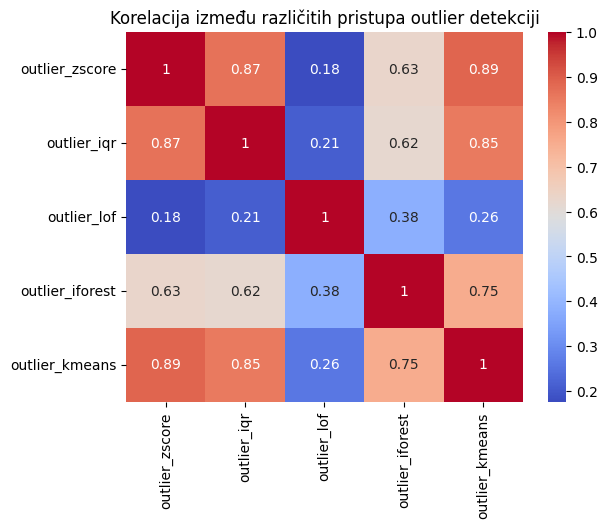

In [305]:
sns.heatmap(df[["outlier_zscore", "outlier_iqr", "outlier_lof", "outlier_iforest", "outlier_kmeans"]].corr(), annot=True, cmap="coolwarm")
plt.title("Korelacija između različitih pristupa outlier detekciji")
plt.show()

**Visoka korelacija (≈ 0.85–0.9)**

Metode `outlier_zscore`, `outlier_iqr` i `outlier_kmeans` su međusobno veoma slične.

- Ove metode u velikoj meri označavaju iste tačke kao outliere.
- Mogu se smatrati redundantnim u većini slučajeva.

**Srednja korelacija (≈ 0.6–0.75)**

Metoda `outlier_iforest` (Isolation Forest) ima umerenu sličnost sa statističkim metodama (`Z-score`, `IQR`) i `K-means`.

- Ponekad detektuje iste outliere kao prethodne metode.
- Ipak, uočava i neke drugačije obrasce, što je čini potencijalno korisnom kao dodatak.

**Niska korelacija (≈ 0.2–0.3)**

Metoda `outlier_lof` (Local Outlier Factor) skoro uopšte ne liči na ostale metode.

- Detekcija outliera se zasniva na **lokalnoj gustini podataka**.
- Prepoznaje instancije koje su **izolovane u malim lokalnim grupama**, za razliku od globalnih metoda.

## Algoritmi za filtriranje šuma (filtri)

### Ensemble Filter

In [362]:
X = numeric_df.drop(columns=["fall_detected"]) 
y = df["fall_detected"]

In [364]:
filter_algorithms = [ # μ filter algoritmi
    RandomForestClassifier(n_estimators=50, random_state=42),
    GradientBoostingClassifier(random_state=42),
    make_pipeline(StandardScaler(),
                  LogisticRegression(solver="liblinear", max_iter=5000, random_state=42))
]

Gamma = 5 # Parametar Γ (broj foldova za cross-validation)
skf = StratifiedKFold(n_splits=Gamma, shuffle=True, random_state=42)

noise_votes = np.zeros(len(X)) # Matrica predikcija: za svaku instancu pamtim koliko puta je označena kao noisy

for clf in filter_algorithms: # K-fold cross-validation
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        misclassified = (y_pred != y_test).astype(int) # Ako je instanca pogrešno klasifikovana → povećaj broj glasova za "noisy"
        noise_votes[test_idx] += misclassified

threshold = len(filter_algorithms) / 2 # Prag odlučivanja – većina filter algoritama označila kao noisy
noisy_instances = np.where(noise_votes >= threshold)[0]

X_clean = X.drop(index=noisy_instances)
y_clean = y.drop(index=noisy_instances)

In [366]:
print(f"Ukupno instanci: {len(X)}")
print(f"Detektovano bučnih instanci: {len(noisy_instances)}")
print(f"Nakon filtriranja: {len(X_clean)} instanci")

Ukupno instanci: 670
Detektovano bučnih instanci: 28
Nakon filtriranja: 642 instanci


### Cross-Validated Committees Filter (CVCF)

In [368]:
X = numeric_df.drop(columns=["fall_detected"]) 
y = df["fall_detected"] # Npr: ciljna kolona = "fall_detected"

In [370]:
Gamma = 5
skf = StratifiedKFold(n_splits=Gamma, shuffle=True, random_state=42)

votes = np.zeros(len(X)) # Broj glasova da li je instanca "pogrešna"

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    clf = DecisionTreeClassifier(criterion="entropy", random_state=42) # Glavni algoritam = DecisionTreeClassifier
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    misclassified = (y_pred != y_test).astype(int) # Ako instanca NIJE pogođena → smatram da je noisy
    votes[test_idx] += misclassified

threshold = Gamma / 2
noisy_instances = np.where(votes >= threshold)[0]

X_clean = X.drop(index=noisy_instances)
y_clean = y.drop(index=noisy_instances)

In [372]:
print("===== Cross-Validated Committees Filter (CVCF) =====")
print(f"Ukupno instanci: {len(X)}")
print(f"Detektovano bučnih instanci: {len(noisy_instances)}")
print(f"Nakon filtriranja: {len(X_clean)} instanci")

===== Cross-Validated Committees Filter (CVCF) =====
Ukupno instanci: 670
Detektovano bučnih instanci: 0
Nakon filtriranja: 670 instanci


### Iterative-Partitioning Filter (IPF)

In [42]:
def iterative_partitioning_filter(X, y, max_iter=10, gamma=5, p=0.01, y_fraction=0.05):
    # p: prag (% originalnog skupa) ispod koga se filter zaustavlja
    # y_fraction: procenat "dobrih" instanci koji se uklanja u svakoj iteraciji
    
    X, y = np.array(X), np.array(y)
    n = len(y)
    DT = np.arange(n)  # indeksi preostalih instanci
    
    for iteration in range(max_iter):
        print(f"\n=== Iteracija {iteration+1} ===")
        
        kf = KFold(n_splits=gamma, shuffle=True, random_state=iteration)
        preds = np.zeros((len(DT), gamma), dtype=object)
        
        for i, (train_idx, val_idx) in enumerate(kf.split(DT)):
            train_ids, val_ids = DT[train_idx], DT[val_idx]
            clf = DecisionTreeClassifier(random_state=iteration)
            clf.fit(X[train_ids], y[train_ids])
            preds[val_idx, i] = clf.predict(X[val_ids])
        
        maj_preds = [] # većinsko glasanje
        for i in range(len(DT)):
            votes, counts = np.unique(preds[i], return_counts=True)
            maj_preds.append(votes[np.argmax(counts)])
        maj_preds = np.array(maj_preds)
        
        noisy_idx = DT[maj_preds != y[DT]]
        good_idx = DT[maj_preds == y[DT]]
        
        print(f"Detektovano šumnih instanci: {len(noisy_idx)}")
     
        if len(noisy_idx) < p * n:
            print("Zaustavljam - broj šumnih ispod praga.")
            break
        
        n_good_remove = int(len(DT) * y_fraction) 
        if n_good_remove > 0:
            good_remove = np.random.choice(good_idx, size=n_good_remove, replace=False)
        else:
            good_remove = np.array([])
       
        remove_idx = np.concatenate([noisy_idx, good_remove])
        DT = np.setdiff1d(DT, remove_idx)  # DT ← DT \ {DN ∪ DG}
        print(f"Nakon uklanjanja ostalo: {len(DT)} instanci")
    
    return X[DT], y[DT]

In [380]:
X = numeric_df.drop(columns=["fall_detected"]) 
y = df["fall_detected"]

X_clean, y_clean = iterative_partitioning_filter(X, y, max_iter=10, gamma=5, p=0.01, y_fraction=0.05)


=== Iteracija 1 ===
Detektovano šumnih instanci: 28
Nakon uklanjanja ostalo: 609 instanci

=== Iteracija 2 ===
Detektovano šumnih instanci: 0
Zaustavljam - broj šumnih ispod praga.


In [382]:
print("Originalna veličina:", len(y))
print("Očišćena veličina:", len(y_clean))

Originalna veličina: 670
Očišćena veličina: 609
